In [1]:
import os
import sys
import numpy as np

from transformers import AutoTokenizer, LlamaForCausalLM
import torch
import torch.nn.functional as F

In [2]:
sys.path.append("..")

In [3]:
from models.llama3.transformer import Transformer
from models.llama3.tokenizer import Tokenizer
from models.llama3.config import LlamaConfig
from models.llama3.load import build

In [19]:
def hf_main(prompts):
    device = "mps"
    model_id = "meta-llama/Llama-3.2-3B"
    os.environ["TOKENIZERS_PARALLELISM"] = "true"
    tokenizer = AutoTokenizer.from_pretrained(model_id)
    tokenizer.add_special_tokens({'pad_token': tokenizer.eos_token})
    # prompts = ["The theory of relativity states that"]
    print(prompts[0])
    inputs = tokenizer(prompts, return_tensors="pt")
    print(inputs["input_ids"].numpy().tolist())
    # [[128000, 791, 10334, 315, 1375, 44515, 5415, 430]]
    inputs = {k:v.to(device) for k,v in inputs.items()}
    model = LlamaForCausalLM.from_pretrained(model_id).to(device)
    model.generation_config.pad_token_id = model.config.eos_token_id
    """
    /Users/jyotirmaya.mahanta/projects/thelonejordan/personal/deeplearning.scratchpad/.venv/lib/python3.11/site-packages/transformers/generation/configuration_utils.py:628: UserWarning: `do_sample` is set to `False`. However, `temperature` is set to `0.6` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `temperature`.
    warnings.warn(
    /Users/jyotirmaya.mahanta/projects/thelonejordan/personal/deeplearning.scratchpad/.venv/lib/python3.11/site-packages/transformers/generation/configuration_utils.py:633: UserWarning: `do_sample` is set to `False`. However, `top_p` is set to `0.9` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `top_p`.
    warnings.warn(
    """
    outputs = model.generate(**inputs, max_length=19, do_sample=False, temperature=None, top_p=None)
    print(model.generation_config)
    print(outputs.cpu().numpy().tolist())
    # [[128000, 791, 10334, 315, 1375, 44515, 5415, 430, 279, 4732, 315, 3177, 374, 6926, 304, 682, 5905, 14418, 13, 1115, 3445, 430, 422, 499, 527, 7366, 520, 264, 6926, 4732]]
    texts = tokenizer.batch_decode(outputs, skip_special_tokens=True, clean_up_tokenization_spaces=False)
    print(texts[0])
    # The theory of relativity states that the speed of light is constant in all reference frames. This means that if you are moving at a constant speed
    return model, tokenizer, model.config, model.generation_config, device, inputs, texts[0]

In [20]:
@torch.inference_mode()
def generate(prompt_tokens: list[str],model: Transformer, tokenizer: Tokenizer, config: LlamaConfig, device, logprobs: bool=False):
  max_batch_size, max_seq_len = config.max_batch_size, config.max_seq_len
  bsz = len(prompt_tokens)
  assert bsz <= max_batch_size, (bsz, max_batch_size)
  max_gen_len = config.max_seq_len
  min_prompt_len = min(len(t) for t in prompt_tokens)
  max_prompt_len = max(len(t) for t in prompt_tokens)
  assert max_prompt_len <= max_seq_len
  total_len = min(max_seq_len, max_gen_len + max_prompt_len)
  pad_id = tokenizer.pad_id
  tokens = torch.full((bsz, total_len), pad_id, dtype=torch.long, device=device)
  for k, t in enumerate(prompt_tokens):
    tokens[k, : len(t)] = torch.tensor(t, dtype=torch.long, device=device)
  if logprobs:
    token_logprobs = torch.zeros_like(tokens, dtype=torch.float)
  prev_pos = 0
  eos_reached = torch.tensor([False] * bsz, device=device)
  input_text_mask = tokens != pad_id
  if min_prompt_len == total_len:
    logits = model.forward(tokens, prev_pos)
    token_logprobs = -F.cross_entropy(
      input=logits.transpose(1, 2),
      target=tokens,
      reduction="none",
      ignore_index=pad_id,
    )
  stop_tokens = torch.tensor(list(tokenizer.stop_tokens), device=device)

  for cur_pos in range(min_prompt_len, total_len):
    logits = model.forward(tokens[:, prev_pos:cur_pos], prev_pos)
    probs = torch.softmax(logits[:, -1], dim=-1)
    next_token = torch.argmax(logits[:, -1], dim=-1)
    next_token = next_token.reshape(-1)
    # only replace token if prompt has already been generated
    next_token = torch.where(
      input_text_mask[:, cur_pos], tokens[:, cur_pos], next_token
    )
    tokens[:, cur_pos] = next_token
    if logprobs:
      token_logprobs[:, prev_pos + 1 : cur_pos + 1] = -F.cross_entropy(
        input=logits.transpose(1, 2),
        target=tokens[:, prev_pos + 1 : cur_pos + 1],
        reduction="none",
        ignore_index=pad_id,
      )
    eos_reached |= (~input_text_mask[:, cur_pos]) & (
      torch.isin(next_token, stop_tokens)
    )
    prev_pos = cur_pos
    if all(eos_reached):
      break
  if logprobs:
    token_logprobs = token_logprobs.tolist()  # type: ignore
  out_tokens, out_logprobs = [], []
  for i, toks in enumerate(tokens.tolist()):
    # cut to max gen len
    start = 0
    toks = toks[start : len(prompt_tokens[i]) + max_gen_len]
    if logprobs:
      probs = token_logprobs[i][start : len(prompt_tokens[i]) + max_gen_len]
    # cut to after eos tok if any
    for stop_token in tokenizer.stop_tokens:
      try:
        eos_idx = toks.index(stop_token)
        toks = toks[:eos_idx]
        if logprobs:
          probs = probs[:eos_idx]
      except ValueError:
        pass
    out_tokens.append(toks)
    out_logprobs.append(probs)
  return out_tokens, (out_logprobs if logprobs else None)

In [21]:
import functools

def my_main(prompts, safetensors=False):
    device = "mps"
    model, tokenizer, config = build(
        max_seq_len=19,
        max_batch_size=1,
        model_desc="3B",
        version=2,
        safetensors=safetensors,
    )
    model = model.to(device)
    # prompts = ["The theory of relativity states that"]
    print(prompts[0])
    tokenizer.pad_id = tokenizer.eos_id
    inputs = [tokenizer.encode(s, bos=True, eos=False) for s in prompts]
    print(inputs)
    # [[128000, 791, 10334, 315, 1375, 44515, 5415, 430]]
    outputs, logprobs = generate(inputs, model, tokenizer, config, device, logprobs=False)
    print(outputs)
    # [[128000, 791, 10334, 315, 1375, 44515, 5415, 430, 279, 4732, 315, 3177, 374, 6926, 304, 682, 5905, 14418, 315, 5905, 13, 578, 10334, 315, 1375, 44515, 374, 264, 10334, 315]]
    outputs = [i[i.index(tokenizer.bos_id)+1:]for i in outputs]
    texts = [tokenizer.decode(toks) for toks in outputs]
    print(texts[0])
    # print(np.exp(np.array(logprobs, dtype=np.float32)).tolist())
    return model, tokenizer, config, None, device, inputs, texts[0]


my_main_torch = functools.partial(my_main, safetensors=False)
my_main_safetensors = functools.partial(my_main, safetensors=True)

In [22]:
from dataclasses import dataclass
from typing import Any

@dataclass
class Benchmark:
    model: torch.nn.Module
    tokenizer: Any
    config: Any
    generation_config: Any
    device: Any
    inp: list[list[int]]
    out: list[list[int]]

In [23]:
# prompts = ["The theory of relativity states that"]
prompts = ["The theory of relativity states that the speed of light is constant in all reference frames"]

In [24]:
bench_hf = Benchmark(*hf_main(prompts))

The theory of relativity states that the speed of light is constant in all reference frames
[[128000, 791, 10334, 315, 1375, 44515, 5415, 430, 279, 4732, 315, 3177, 374, 6926, 304, 682, 5905, 14418]]


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

GenerationConfig {
  "bos_token_id": 128000,
  "do_sample": true,
  "eos_token_id": 128001,
  "pad_token_id": 128001,
  "temperature": 0.6,
  "top_p": 0.9
}

[[128000, 791, 10334, 315, 1375, 44515, 5415, 430, 279, 4732, 315, 3177, 374, 6926, 304, 682, 5905, 14418, 13]]
The theory of relativity states that the speed of light is constant in all reference frames.


In [25]:
bench_cu = Benchmark(*my_main_safetensors(prompts))

Fetching 1 files:   0%|          | 0/1 [00:00<?, ?it/s]

Fetching 1 files:   0%|          | 0/1 [00:00<?, ?it/s]

Reloaded tiktoken model from /Users/jyotirmaya.mahanta/.cache/huggingface/hub/models--meta-llama--Llama-3.2-3B/snapshots/13afe5124825b4f3751f836b40dafda64c1ed062/original/tokenizer.model
#words: 128256 - BOS ID: 128000 - EOS ID: 128001


Fetching 2 files:   0%|          | 0/2 [00:00<?, ?it/s]

number of parameters: 3.21B
The theory of relativity states that the speed of light is constant in all reference frames
[[128000, 791, 10334, 315, 1375, 44515, 5415, 430, 279, 4732, 315, 3177, 374, 6926, 304, 682, 5905, 14418]]
[[128000, 791, 10334, 315, 1375, 44515, 5415, 430, 279, 4732, 315, 3177, 374, 6926, 304, 682, 5905, 14418, 315]]
The theory of relativity states that the speed of light is constant in all reference frames of


In [14]:
# bench_cu.tokenizer.decode([128000, 791, 10334, 315, 1375, 44515, 5415, 430, 279, 4732, 315, 3177, 374, 6926, 304, 682, 5905, 14418])

'<|begin_of_text|>The theory of relativity states that the speed of light is constant in all reference frames'

In [18]:
len([128000, 791, 10334, 315, 1375, 44515, 5415, 430, 279, 4732, 315, 3177, 374, 6926, 304, 682, 5905, 14418])

18

In [34]:
pad_id = bench_cu.tokenizer.pad_id
bsz = 1
total_len = 19
device = "mps"
prompt_tokens = [[128000, 791, 10334, 315, 1375, 44515, 5415, 430, 279, 4732, 315, 3177, 374, 6926, 304, 682, 5905, 14418]]

In [38]:
with torch.inference_mode():
    tokens = torch.full((bsz, total_len), pad_id, dtype=torch.long, device=device)
    for k, t in enumerate(prompt_tokens):
        tokens[k, : len(t)] = torch.tensor(t, dtype=torch.long, device=device)

In [39]:
with torch.inference_mode():
    out = bench_cu.model.forward()
out.shape, out.mean(), out.var()

torch.Size([1, 19, 128256])

(tensor(-0.2307, device='mps:0', dtype=torch.float32),
 tensor(6.1717, device='mps:0', dtype=torch.float32))

In [44]:
pad_id = bench_hf.tokenizer.pad_token_id

128001

In [53]:
with torch.inference_mode():
    out = bench_hf.model.forward(tokens)

In [55]:
logits = out.logits
logits.shape, logits.mean(), logits.var()

(torch.Size([1, 19, 128256]),
 tensor(-0.8320, device='mps:0'),
 tensor(6.0625, device='mps:0'))

In [11]:
type(bench_hf.model.generation_config)

transformers.generation.configuration_utils.GenerationConfig

In [12]:
bench_hf.model

LlamaForCausalLM(
  (model): LlamaModel(
    (embed_tokens): Embedding(128256, 3072)
    (layers): ModuleList(
      (0-27): 28 x LlamaDecoderLayer(
        (self_attn): LlamaSdpaAttention(
          (q_proj): Linear(in_features=3072, out_features=3072, bias=False)
          (k_proj): Linear(in_features=3072, out_features=1024, bias=False)
          (v_proj): Linear(in_features=3072, out_features=1024, bias=False)
          (o_proj): Linear(in_features=3072, out_features=3072, bias=False)
          (rotary_emb): LlamaRotaryEmbedding()
        )
        (mlp): LlamaMLP(
          (gate_proj): Linear(in_features=3072, out_features=8192, bias=False)
          (up_proj): Linear(in_features=3072, out_features=8192, bias=False)
          (down_proj): Linear(in_features=8192, out_features=3072, bias=False)
          (act_fn): SiLU()
        )
        (input_layernorm): LlamaRMSNorm((3072,), eps=1e-05)
        (post_attention_layernorm): LlamaRMSNorm((3072,), eps=1e-05)
      )
    )
    (norm

In [13]:
bench_cu.model

Transformer(
  (model): ModuleDict(
    (embed_tokens): Embedding(128256, 3072)
    (layers): ModuleList(
      (0-27): 28 x Block(
        (input_layernorm): RMSNorm()
        (self_attn): Attention(
          (q_proj): Linear(in_features=3072, out_features=3072, bias=False)
          (k_proj): Linear(in_features=3072, out_features=1024, bias=False)
          (v_proj): Linear(in_features=3072, out_features=1024, bias=False)
          (o_proj): Linear(in_features=3072, out_features=3072, bias=False)
        )
        (post_attention_layernorm): RMSNorm()
        (mlp): FeedForward(
          (gate_proj): Linear(in_features=3072, out_features=8192, bias=False)
          (up_proj): Linear(in_features=3072, out_features=8192, bias=False)
          (down_proj): Linear(in_features=8192, out_features=3072, bias=False)
        )
      )
    )
    (norm): RMSNorm()
  )
  (lm_head): Linear(in_features=3072, out_features=128256, bias=False)
)

In [39]:
bench_cu.model.model.layers[0].self_attn.q_proj.weight.data.shape

torch.Size([3072, 3072])

In [29]:
import matplotlib.pyplot as plt

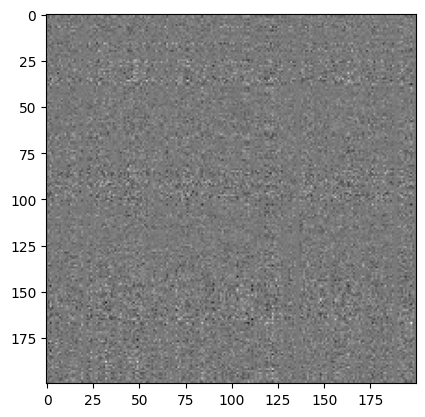

In [48]:
plt.imshow(bench_cu.model.model.layers[0].self_attn.k_proj.weight.data.float().cpu()[:200, :200], cmap='gray')

In [15]:
bench_hf.model.model.layers[0].self_attn.q_proj.weight.data

tensor([[-0.0337,  0.0289,  0.0623,  ...,  0.0854, -0.0334, -0.0183],
        [-0.0110, -0.0240,  0.0432,  ...,  0.0544,  0.0007, -0.0352],
        [ 0.0211,  0.0173,  0.0332,  ...,  0.0513, -0.0403, -0.0129],
        ...,
        [ 0.0034, -0.0079,  0.0698,  ..., -0.0099,  0.0060,  0.0110],
        [ 0.0074, -0.0125,  0.0204,  ..., -0.0109, -0.0197,  0.0095],
        [-0.0079,  0.0239, -0.0073,  ...,  0.0077,  0.0044, -0.0112]],
       device='mps:0', dtype=torch.float32)

In [16]:
# https://github.com/huggingface/transformers/blob/e42587f596181396e1c4b63660abf0c736b10dae/src/transformers/models/llama/convert_llama_weights_to_hf.py#L164
n_heads, dim = bench_cu.config.n_heads, bench_cu.config.dim
def permute(w, n_heads=n_heads, dim1=dim, dim2=dim):
    return w.view(n_heads, dim1 // n_heads // 2, 2, dim2).transpose(1, 2).reshape(dim1, dim2)